## Imports

In [1]:
import scipy.io
from scipy import signal
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from sklearn.decomposition import PCA
import seaborn as sb

## Load and prepare Data

In [2]:
# from https://crcns.org/data-sets/hc/hc-30/about-hc-30
mat_file_path = 'data/event_traces_Ca2_HPC.mat'

mat_data = scipy.io.loadmat(mat_file_path)['event_traces']

In [3]:
def generate_calcium_traces(trace_matrix, tau=0.2, frequency=20, start_time=0.05, end_time=1.5, epsilon=1e-10):
    t = np.arange(start_time, end_time, 1/frequency)
    alpha = (t / tau) * np.exp(1 - t / tau)
    convolved_traces = np.zeros_like(trace_matrix)

    for i in range(trace_matrix.shape[1]):
        convolved_traces[:, i] = scipy.signal.convolve(trace_matrix[:, i], alpha, mode='same')

    peak_std_devs = np.zeros(trace_matrix.shape[1])
    for i in range(trace_matrix.shape[1]):
        peaks = trace_matrix[:, i][np.nonzero(trace_matrix[:, i])]
        if len(peaks) > 1:
            peak_std_devs[i] = np.std(peaks)
        else:
            peak_std_devs[i] = epsilon
    peak_std_devs += epsilon
    
    normalized_traces = convolved_traces / peak_std_devs

    return normalized_traces

In [4]:
def normalize_calcium_peaks(trace_matrix, epsilon=1e-10):
    peak_std_devs = np.zeros(trace_matrix.shape[1])
    for i in range(trace_matrix.shape[1]):
        peaks = trace_matrix[:, i][np.nonzero(trace_matrix[:, i])]
        if len(peaks) > 1:
            peak_std_devs[i] = np.std(peaks)
        else:
            peak_std_devs[i] = epsilon
    peak_std_devs += epsilon
    
    normalized_traces = trace_matrix / peak_std_devs

    return normalized_traces

In [5]:
data = {}

for record in mat_data[0]:
    mouse_name = record['mouse_name'][0]
    session_id = record['session_ID'][0]
    event_trace_matrix = record['traces'].toarray()
    
    #traces = generate_calcium_traces(event_trace_matrix)
    traces = normalize_calcium_peaks(event_trace_matrix)
    
    if mouse_name not in data:
        data[mouse_name] = {}

    data[mouse_name][session_id] = traces

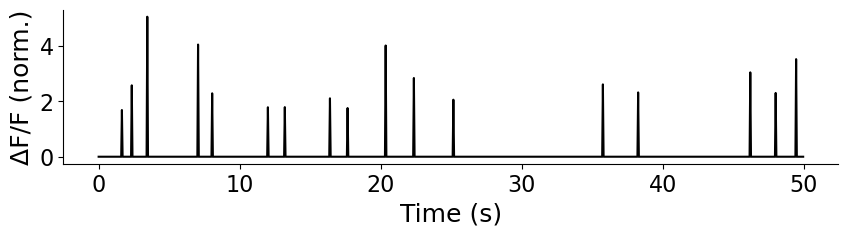

In [6]:
plt.figure(figsize=(10,2))
plt.plot(np.arange(0,traces.shape[0],1/20)[:1000], traces[:1000,5], color='k')

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('ΔF/F (norm.)', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

sb.despine()
#plt.savefig('plots/example_calciumTrace.png', dpi=600)
plt.show()

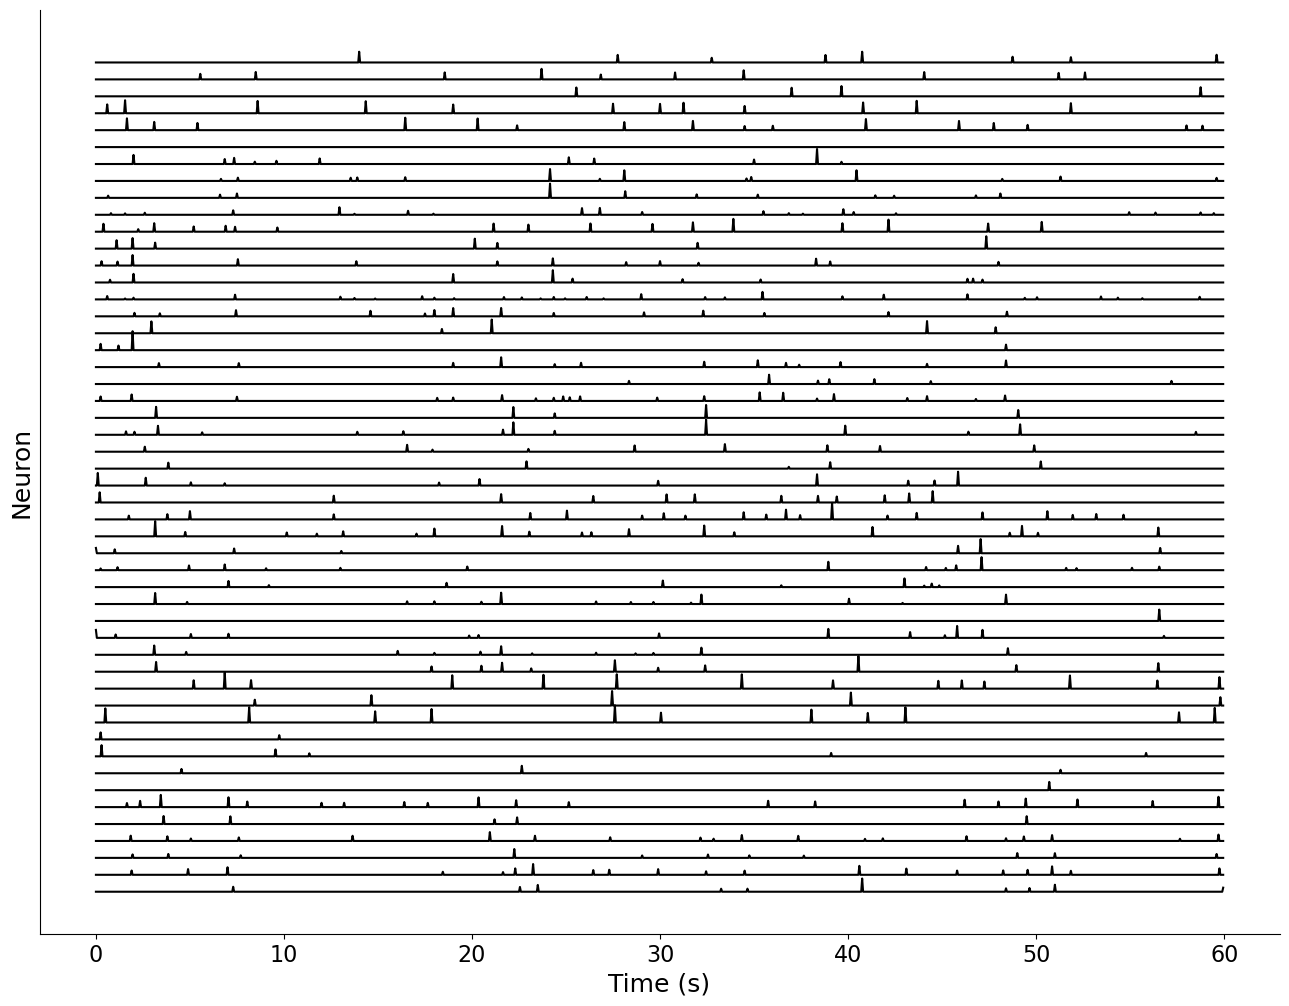

In [7]:
plt.figure(figsize=(16,12))
for i in range(50):
    plt.plot(np.arange(0,traces.shape[0],1/20)[:1200], traces[:1200,i] + i*7, color='k')

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Neuron', fontsize=18)
plt.yticks([])
plt.xticks(fontsize=16)

sb.despine()
#plt.savefig('plots/example_manyCalciumTraces.png', dpi=600)
plt.show()

#### Remove outlier sessions

In [8]:
sessions_to_remove = {
    "Mouse2012": ['100218', '121707']
}

for mouse, sessions in sessions_to_remove.items():
    for session in sessions:
        if session in data[mouse]:
            del data[mouse][session]

## Neural Eigenspectrum

In [10]:
fit_slopes = []
fit_intercepts = []
all_variances = []
for mouse_name, sessions in data.items():
    fit_slopes_mouse = []
    for session_id, trace_matrix in sessions.items():
        trace_matrix_reduced = PCA().fit(trace_matrix)
        variances = trace_matrix_reduced.explained_variance_ratio_
        
        start_fit = 10
        cutoff_fit = 100
        x = np.arange(1, len(variances)+1)
        y = variances
        m, b = np.polyfit(np.log(x[start_fit:cutoff_fit]), np.log(y[start_fit:cutoff_fit]), 1)
        
        fit_slopes_mouse.append(m)
        fit_intercepts.append(b)
        all_variances.append(variances)
    fit_slopes.append(fit_slopes_mouse)

In [11]:
fit_slopes_flattened = [-m for mouse in fit_slopes for m in mouse]

In [12]:
plt.figure(figsize=(16,16), dpi=600)

for i, variances in enumerate(all_variances):
    plt.subplot(10, 11, i+1)

    x = np.arange(1, len(variances)+1)
    y = variances

    plt.plot(x, y, color='blue', linewidth=3, alpha=0.8)
    
    m = -fit_slopes_flattened[i]
    b = fit_intercepts[i]
    
    x_fit = x
    y_fit = np.exp(b) * x_fit**m
    plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)

    plt.title('$\u03B1$='+str(np.around(m, 2)), fontsize=12)
    
    if i >= (10-1)*11-2:
        plt.xlabel('PC dim.', fontsize=12)
    if i%11==0: 
        plt.ylabel('Var.', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')

    sb.despine()

plt.tight_layout()

plt.savefig('plots/calciumData_powerLawFits.png', dpi=600)

plt.show()

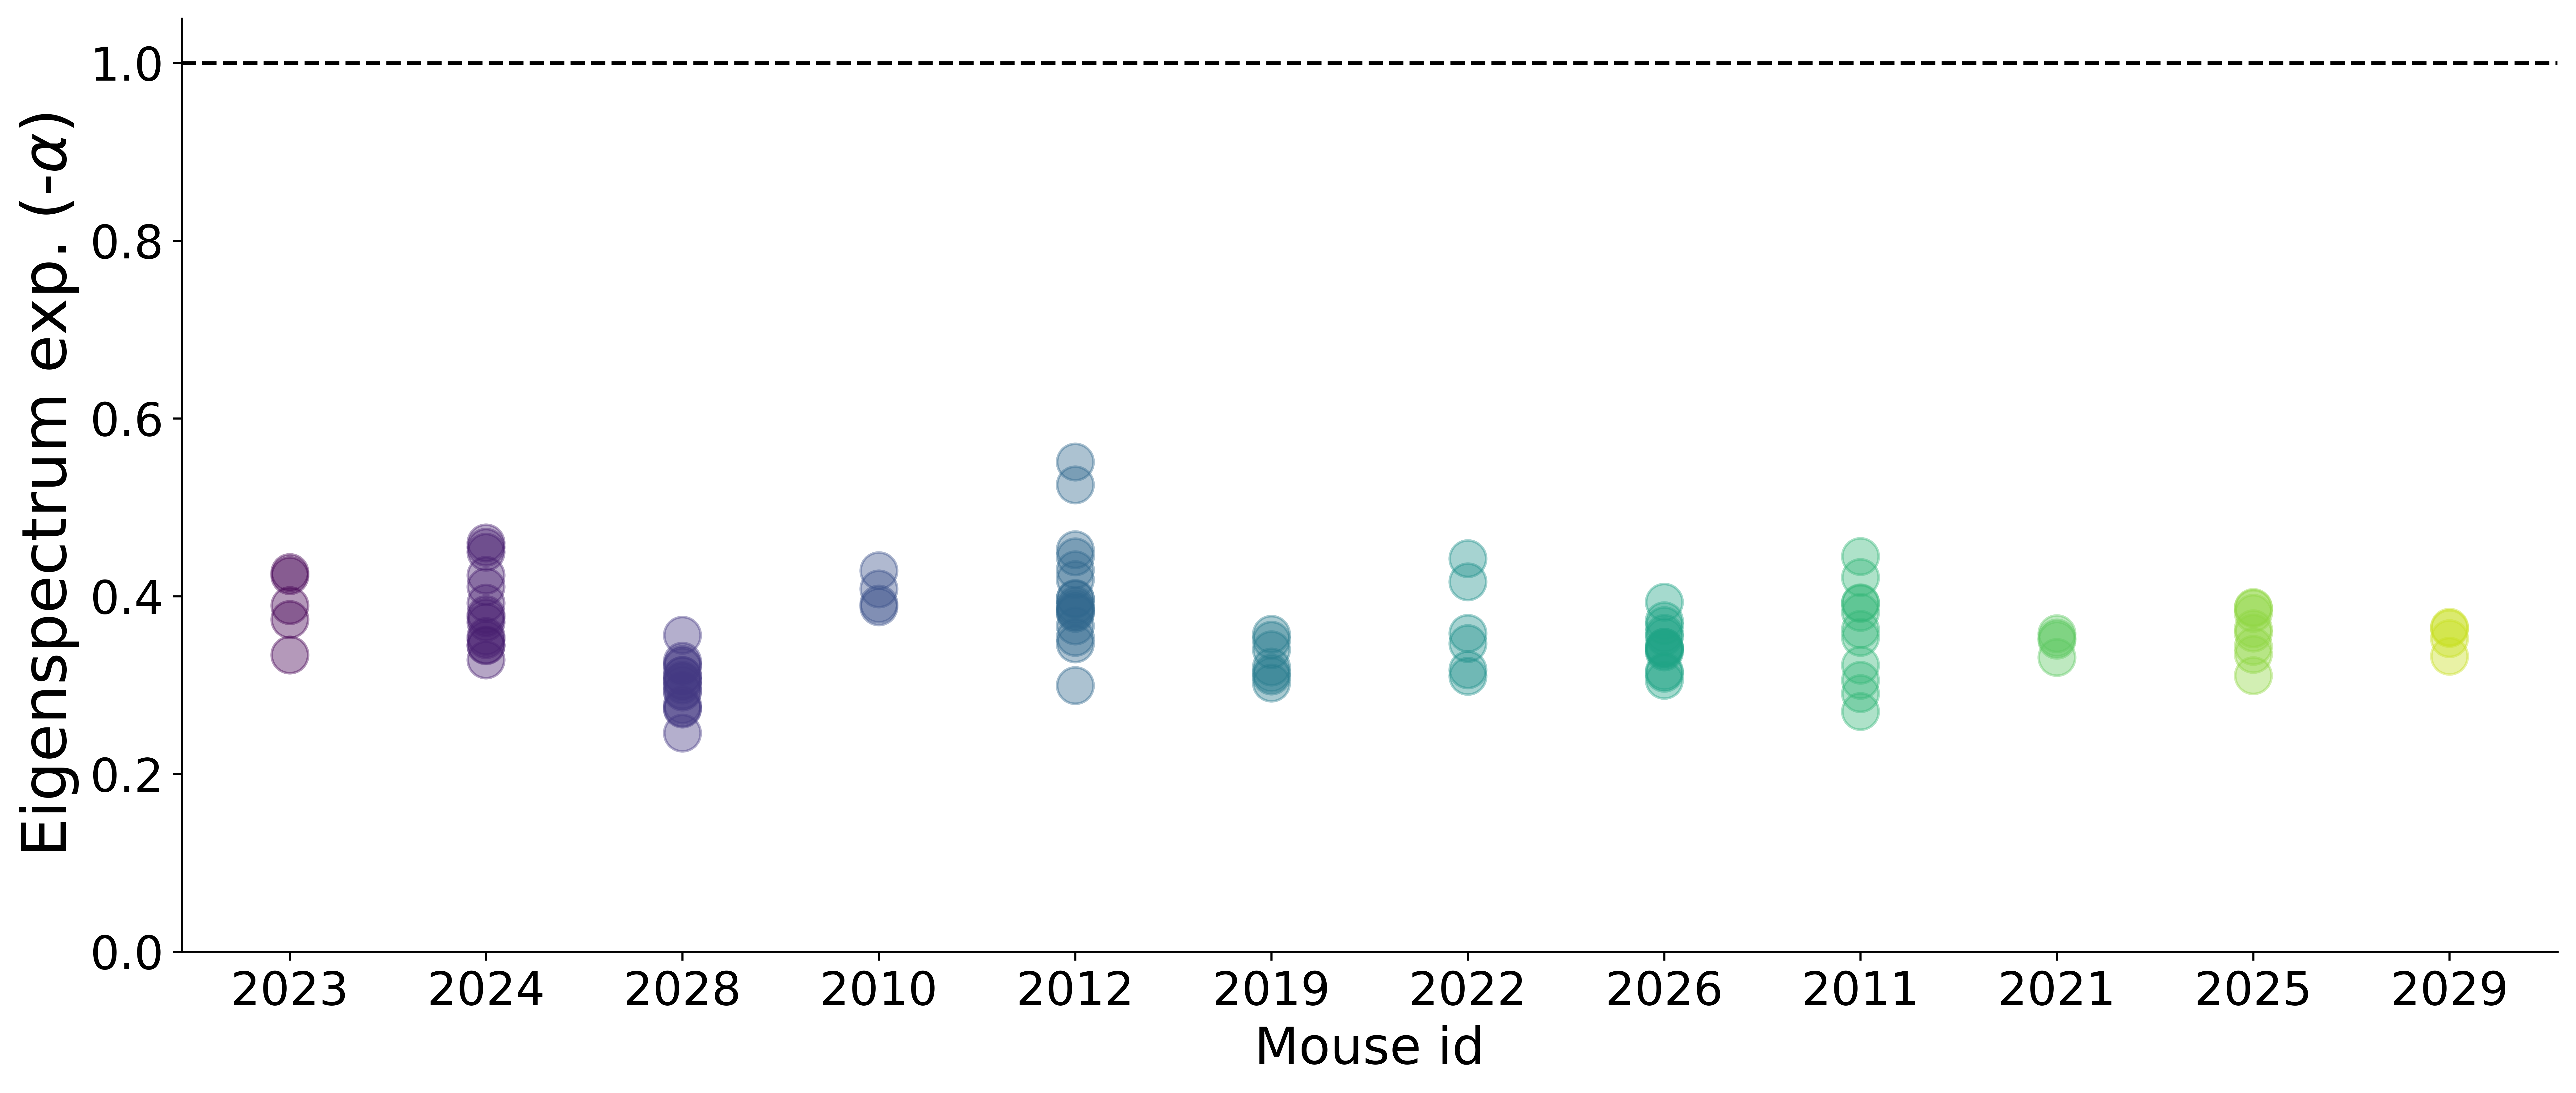

In [19]:
cmap = matplotlib.colormaps.get_cmap('viridis')
colors = [cmap(i/len(fit_slopes)) for i in range(len(fit_slopes))]

plt.figure(figsize=(14, 6), dpi=600)

for i, mouse_name in enumerate(data.keys()):
    plt.scatter([i] * len(fit_slopes[i]), -np.array(fit_slopes[i]), marker='o', s=200, color=colors[i], alpha=0.4, label=mouse_name)

plt.ylabel('Eigenspectrum exp. (-$\u03B1$)', fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(ticks=np.arange(len(data)), labels=[mouse_name[5:] for mouse_name in data.keys()], fontsize=18)
plt.xlabel('Mouse id', fontsize=20)

plt.axhline(y=1, color='k', linestyle='--')

plt.ylim(0,1.05)

sb.despine()
plt.tight_layout()
plt.savefig('plots/calciumData_slopeDistrPerMouse.png', dpi=600)
plt.show()

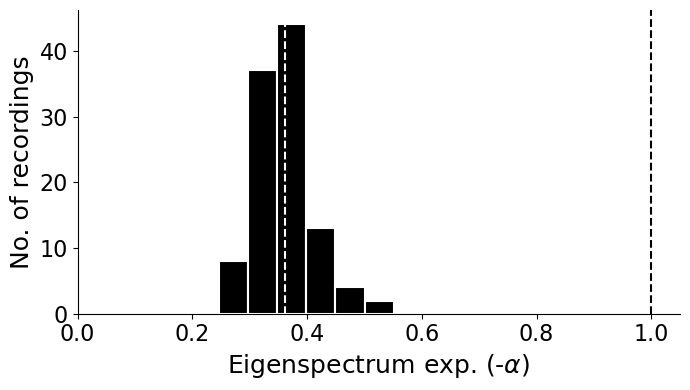

In [18]:
plt.figure(figsize=(7,4))

plt.hist(fit_slopes_flattened, bins=6, color='k', alpha=1, edgecolor='white', linewidth=1.5)
plt.axvline(x=1, color='k', linestyle='--')
plt.axvline(x=np.mean(fit_slopes_flattened), color='white', linestyle='--')

plt.xlim(0,1.05)

plt.xlabel('Eigenspectrum exp. (-$\u03B1$)', fontsize=18)
plt.ylabel('No. of recordings', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

sb.despine()
plt.tight_layout()
plt.savefig('plots/calciumData_slopeDistrAll.png', dpi=600)
plt.show()

## Pairwise correlations

In [15]:
def compute_pairwise_correlations(data, p_value_threshold=0.05):
    """
    Compute the overall pairwise correlation level for each session of each animal.

    Parameters:
    data (dict): A nested dictionary where the first key is the animal ID and the second key is the session ID, 
                 mapping to a data matrix for that session.
    p_value_threshold (float): The threshold for considering correlations as significant.

    Returns:
    correlations (dict): A nested dictionary with the mean correlation for each session of each animal.
    """
    correlations = {}
    for animal_id, sessions in data.items():
        correlations[animal_id] = {}
        for session_id, session_data in sessions.items():
            n_neurons = session_data.shape[1]
            correlation_list = []
            for i in range(n_neurons):
                for j in range(i+1, n_neurons):
                    corr, p_value = pearsonr(session_data[:, i], session_data[:, j])
                    #if p_value < p_value_threshold:
                    correlation_list.append(corr)
            correlations[animal_id][session_id] = correlation_list

    return correlations

In [ ]:
correlations = compute_pairwise_correlations(data, p_value_threshold=0.05)

In [ ]:
all_correlations = [corr for sessions in correlations.values() for correlations_ in sessions.values() for corr in correlations_]

In [16]:
all_correlations = np.load('results/pairwise_corr_values_calcium_CA1.npy')

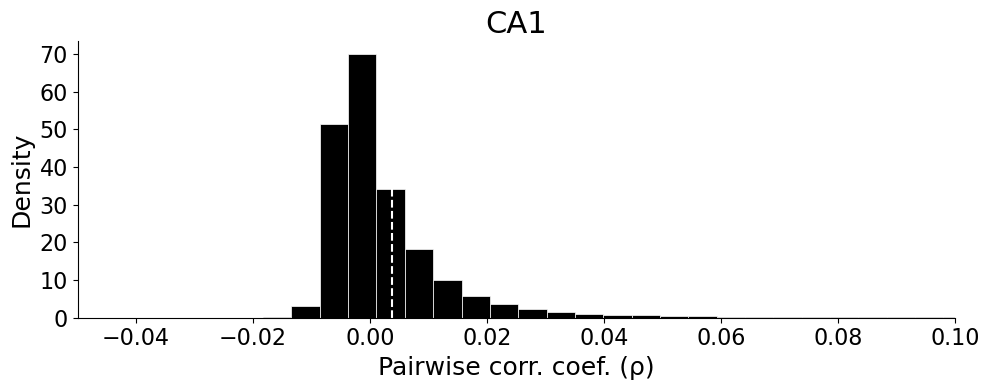

In [17]:
plt.figure(figsize=(10,4))

plt.hist(all_correlations, bins=200, color='k', alpha=1, edgecolor='white', linewidth=.5, density=True)

plt.axvline(x=np.mean(all_correlations), color='white', linestyle='--')

plt.xlabel('Pairwise corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.title('CA1', fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-0.05, 0.1)

sb.despine()
plt.tight_layout()
plt.savefig('plots/pairwiseCorrDistr_CA1.png', dpi=600)
plt.show()

In [45]:
np.save('results/pairwise_corr_values_calcium_CA1.npy', np.array(all_correlations))